### Minimum backtest length (MinBTL)

As seen in *The Effects of Backtest Overfitting on Out-of-Sample Performance* ([Baily, Borwein, López de Prado and Zhu, 2014](http://dx.doi.org/10.1090/noti1105)).  
A more detailed explanation is available in the cited paper, what follows is a summary, not original work.

**Abbreviations**  
IS: in-sample  
OOS: out-of-sample

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

$\mathcal{N}$ represents a normal with mean $\mu$ and variance $\sigma^{2}$.
\begin{align}
r_t &\sim \mathcal{N}(\mu,\,\sigma^{2}) \nonumber
\end{align}

$SR$ is the annualized Sharpe ratio.
\begin{align}
SR &= \frac{\mu}{\sigma}\sqrt{q} \nonumber
\end{align}

Since $\mu$ and $\sigma$ are usually unknown, rather, we use the estimated Sharpe ratio $\widehat{SR}$.  
Based on Lo (2002), we use the asymptomatic approximation with $y \rightarrow \infty$  where $y$ is the number of years used to estimate $\widehat{SR}$.

\begin{align}
\widehat{SR} & \xrightarrow{a} \mathcal{N}\Bigg[SR, \frac{1+\frac{SR^{2}}{2q}}{y}\Bigg] \nonumber
\end{align}

Proposition 1. Given a sample independent and identically distributed random variables., $x_n \sim Z, n = 1, ...,N,$ where $Z$ is the $CDF$ of the Standard Normal distribution, the expected maximum of that sample, $E[max_N] = E[max\{x_n\}]$, can be approximated for a largne N as:

\begin{align}
E[\underset{N}{max}] &\approx (1 - \gamma) Z^{-1}\bigg[1-\frac{1}{N}\bigg]+\gamma Z^{-1} \bigg[1-\frac{1}{N} e^{-1} \bigg] \nonumber
\end{align}
Where $\gamma$ is the Euler-Mascheroni constant.

One implication of proposition 1 is that as the number of strategy configurations tried grows, there will be a a nonnull probability  of selecting IS a strategy with null expected performance OOS.

In the case that $\mu = 0$ but $y \neq 1$, prposition 1 can still be applied by rescaling the expected maximum by the standard deviation of the annualized Sharpe ratio, $y^{-1/2}$. Thus, the "optimal" strategy has an IS annualized Sharpe ratio of:
\begin{align}
E[\underset{N}{max}] &\approx y^{-1/2}\Bigg((1-\gamma)Z^{-1}\Bigg[1-\frac{1}{N}\Bigg]+\gamma Z^{-1}\Bigg[1-\frac{1}{N}e^{-1}\Bigg]\Bigg) \nonumber
\end{align}

The more configurations are tried, overfit is more likely, and therefore the higher the acceptance threshold should be.

\begin{align}
MinBTL &\approx \Bigg(\frac{(1- \gamma) Z^{-1}\big[{1 - \frac{1}{N} \big]}+\gamma Z^{-1}\big[1-\frac{1}{N}e^{-1}\big]}{\overline{E[\max_N]}}\Bigg)^{2} < \frac{2\ln[N]}{\overline{E[\max_N]}^{2}} \nonumber
\end{align}

This tells us that MinBTL must grow as the researcher tries more independent model configurations.

In [2]:
def exp_max_sharpe_IS(N):
    return (1 - np.euler_gamma) * ss.norm.ppf(1-1/N) + (np.euler_gamma * ss.norm.ppf(1-1/N * np.exp(-1)))

def upbound(N):
    return np.sqrt(2 * np.log(N))

def MinBTL(N, obs_sharpe_IS=1):
    return (np.minimum(exp_max_sharpe_IS(N), upbound(N)) / obs_sharpe_IS)**2

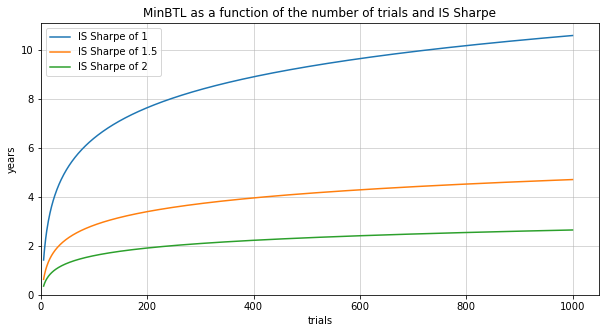

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
trials = np.arange(5, 1001)
ax.plot(trials, MinBTL(N=trials, obs_sharpe_IS=1), label="IS Sharpe of 1")
ax.plot(trials, MinBTL(N=trials, obs_sharpe_IS=1.5), label="IS Sharpe of 1.5")
ax.plot(trials, MinBTL(N=trials, obs_sharpe_IS=2), label="IS Sharpe of 2")
ax.grid(linestyle='-', linewidth=.5)
ax.set_ylabel("years")
ax.set_xlabel("trials")
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0)
ax.legend()
ax.set_title("MinBTL as a function of the number of trials and IS Sharpe");

Interpretation: *if only 5 years of data are available, no more than 45 independent model configurations should be  tried. For that number of trials, the expected maximum SR IS is 1, whereas the expected SR OOS is 0*.

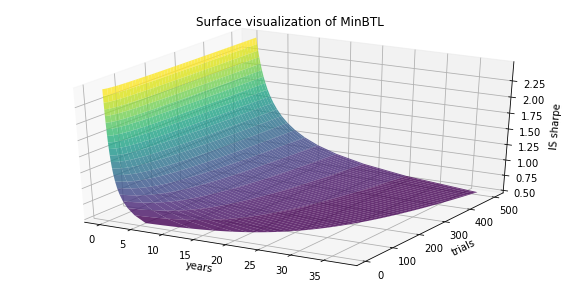

In [4]:
x = np.arange(5, 501)
y = np.arange(.5, 2.6, .1)
X, Y = np.meshgrid(x, y)
Z = MinBTL(X, Y)

fig, ax = plt.subplots(figsize=(10,5))
ax = plt.axes(projection="3d")
ax.plot_surface(Z, X, Y, cmap="viridis", edgecolor="none", alpha=.8)
ax.set_xlabel("years")
ax.set_ylabel("trials")
ax.set_zlabel("IS sharpe")
ax.set_title("Surface visualization of MinBTL");